In [167]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as m
from geopy.distance import geodesic
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
import itertools


%matplotlib inline


In [230]:
df = pd.read_csv("./dataset.csv")
df.drop_duplicates(keep=False,inplace=True)
df["price"] = df["price_sqm"]*df["living_area_sqm"]
df.describe()

,longitude,latitude,price_sqm,living_area_sqm,price
count,854.000000,854.000000,854.000000,854.000000,8.540000e+02
mean,25.133267,60.589776,4706.864169,62.810070,2.894019e+05
std,0.014991,0.011766,1103.813571,25.609431,1.358315e+05
min,25.056955,60.579643,2546.000000,18.500000,1.047280e+05
25%,25.127293,60.584483,3950.250000,45.925000,1.965310e+05
50%,25.135464,60.590007,4569.500000,58.250000,2.515562e+05
75%,25.139544,60.593318,5282.750000,78.000000,3.433500e+05
max,25.321518,60.785485,9461.000000,190.000000,1.318650e+06


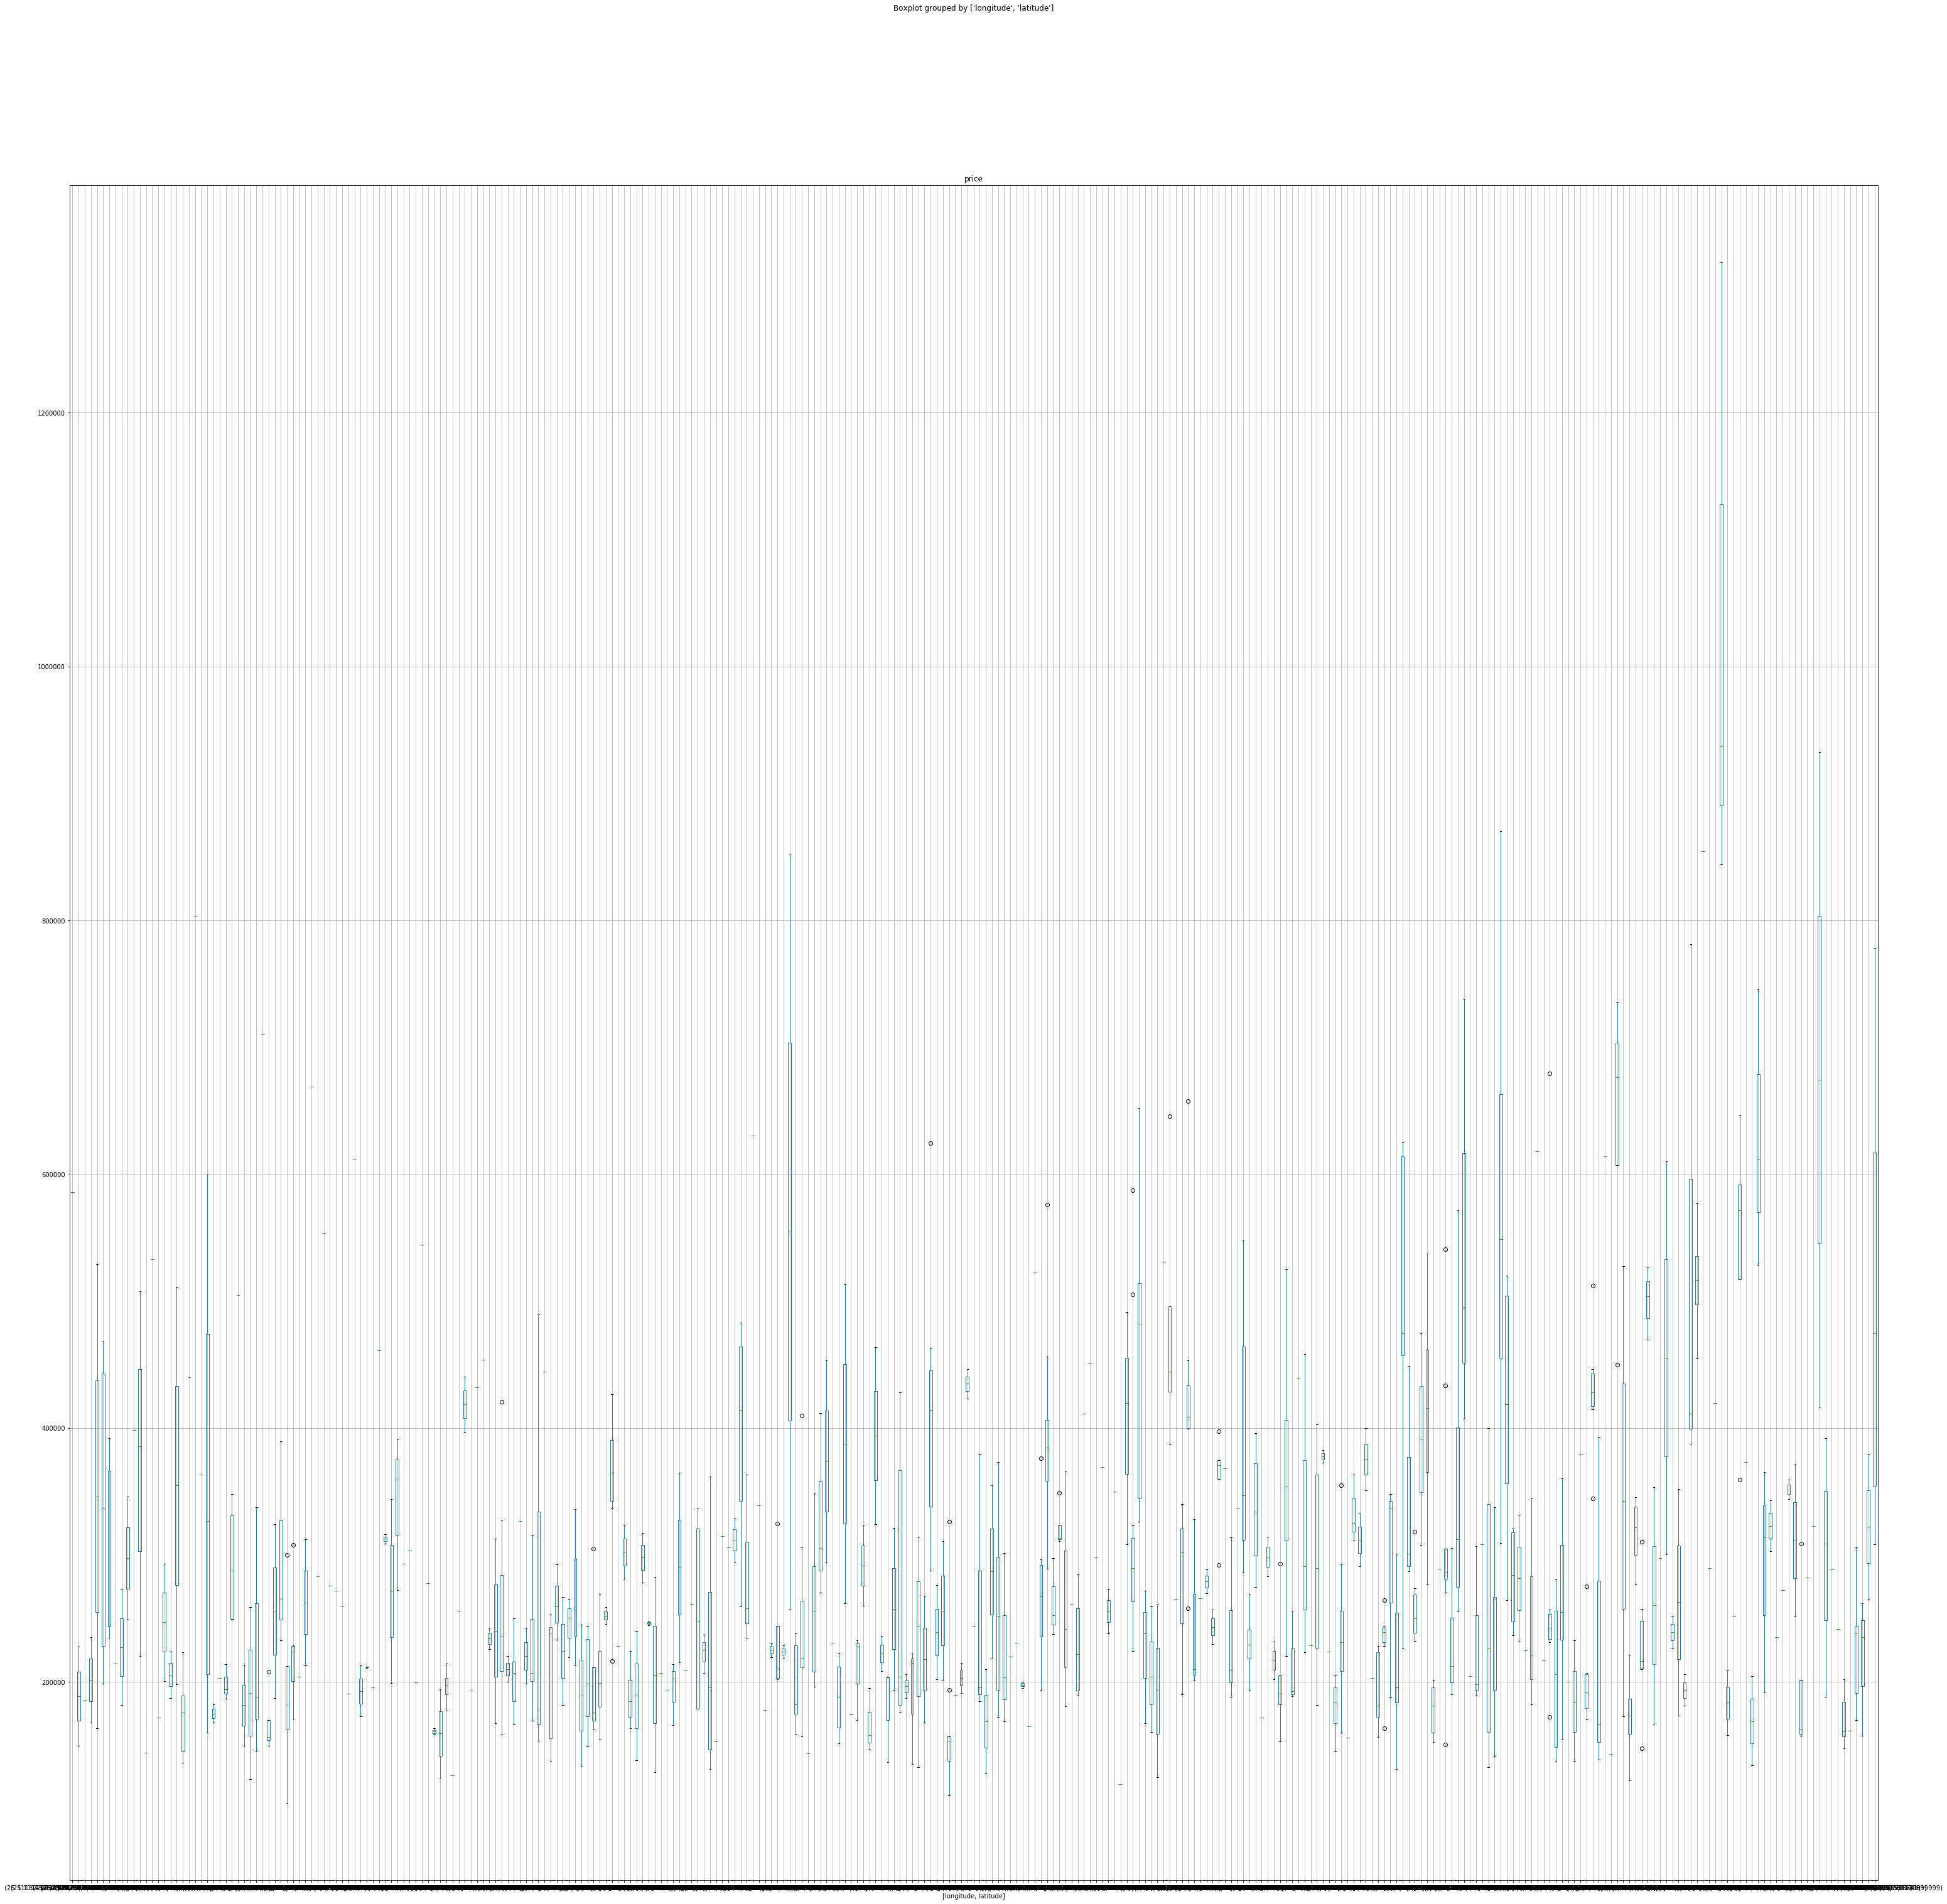

In [229]:
fig,ax = plt.subplots(figsize=(50,50))
df.boxplot("price",["longitude","latitude"],ax=ax)

In [232]:
df.drop_duplicates(keep=False,inplace=True)
df["price"] = df["price_sqm"]*df["living_area_sqm"]
df = df.drop(df[(df["latitude"]<60.56) | (df["latitude"]>60.61)].index)
df = df.drop(df[(df["longitude"]<25.1) | (df["longitude"]>25.16)].index)
df.describe()


,longitude,latitude,price_sqm,living_area_sqm,price
count,849.000000,849.000000,849.000000,849.000000,8.490000e+02
mean,25.132784,60.589123,4711.439340,62.695289,2.891875e+05
std,0.009751,0.005401,1105.039795,25.588286,1.360098e+05
min,25.111322,60.579643,2546.000000,18.500000,1.047280e+05
25%,25.127346,60.584474,3954.000000,45.900000,1.958545e+05
50%,25.135464,60.589856,4572.000000,58.000000,2.515235e+05
75%,25.139530,60.593293,5285.000000,77.500000,3.424430e+05
max,25.147101,60.602244,9461.000000,190.000000,1.318650e+06


In [239]:
df_grouped = df.groupby(["longitude","latitude"]).agg(lambda x: list(x)).reset_index()
df_grouped.head()

,longitude,latitude,price_sqm,living_area_sqm,price
0,25.111322,60.597996,[4594],[127.5],[585735.0]
1,25.111436,60.594018,"[5550, 4143]","[27.0, 55.0]","[149850.0, 227865.0]"
2,25.111576,60.593566,[2953],[63.0],[186039.0]
3,25.111578,60.596643,"[4703, 5610]","[50.0, 30.0]","[235150.0, 168300.0]"
4,25.111624,60.588245,"[6543, 4482]","[25.0, 118.0]","[163575.0, 528876.0]"


In [5]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.describe()

,longitude,latitude,price_sqm,living_area_sqm,price
count,849.000000,849.000000,849.000000,849.000000,8.490000e+02
mean,25.132784,60.589123,4711.439340,62.695289,2.891875e+05
std,0.009751,0.005401,1105.039795,25.588286,1.360098e+05
min,25.111322,60.579643,2546.000000,18.500000,1.047280e+05
25%,25.127346,60.584474,3954.000000,45.900000,1.958545e+05
50%,25.135464,60.589856,4572.000000,58.000000,2.515235e+05
75%,25.139530,60.593293,5285.000000,77.500000,3.424430e+05
max,25.147101,60.602244,9461.000000,190.000000,1.318650e+06


In [170]:
map_file = "./planet_25.1,60.56_25.16,60.61-shp/shape/roads.shp"

In [171]:
map_df = gpd.read_file(map_file)

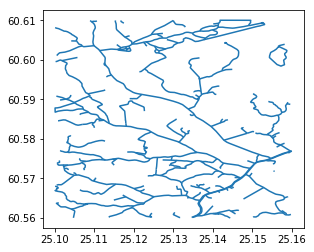

In [172]:
map_df.plot()

In [173]:
def plot_buildings(ax, gdf, map_df):
#     fig.legend()
    map_df.plot(ax = ax, color="green")
    cmap = plt.cm.tab20_r
    gdf.plot(ax=ax,column="cluster",markersize=40,legend=True, categorical=True, cmap=cmap)

In [202]:
df["price_sqm"]=(df["price_sqm"]-df["price_sqm"].min())/(df["price_sqm"].max()-df["price_sqm"].min())

In [203]:
df.describe()

,longitude,latitude,price_sqm,living_area_sqm,price
count,849.000000,849.000000,849.000000,849.000000,849.000000
mean,25.132784,60.589123,0.313151,62.695289,0.151953
std,0.009751,0.005401,0.159803,25.588286,0.112042
min,25.111322,60.579643,0.000000,18.500000,0.000000
25%,25.127346,60.584474,0.203615,45.900000,0.075068
50%,25.135464,60.589856,0.292986,58.000000,0.120927
75%,25.139530,60.593293,0.396095,77.500000,0.195824
max,25.147101,60.602244,1.000000,190.000000,1.000000


In [225]:
mean_df = df.groupby(["longitude","latitude"])["price"].mean().reset_index()
# mean_df["std"] = df.groupby(["longitude","latitude"])["price"].std().values
mean_gdf = gpd.GeoDataFrame(
    mean_df, geometry=gpd.points_from_xy(mean_df.longitude, mean_df.latitude))
mean_gdf.describe()

,longitude,latitude,price
count,295.000000,295.000000,295.000000
mean,25.131288,60.590299,0.159019
std,0.010556,0.005054,0.106921
min,25.111322,60.579643,0.012080
25%,25.124148,60.587289,0.084771
50%,25.134135,60.591657,0.128150
75%,25.139375,60.593756,0.196815
max,25.147101,60.602244,0.764898


No handles with labels found to put in legend.


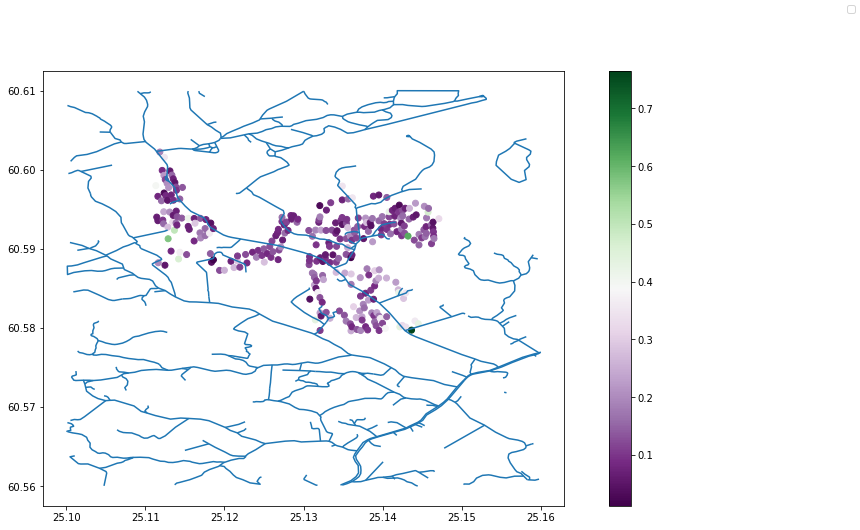

In [177]:
fig,ax = plt.subplots(figsize=(16,8))
fig.legend()

norm = m.colors.Normalize(vmin=mean_df["price"].min(), vmax=mean_df["price"].max())
map_df.plot(ax = ax)
mean_gdf.plot(ax=ax,color=cmap(norm(mean_gdf.price.values)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm)


In [208]:
def price_distance(x,y):
    return abs(x[2]-y[2])

def location_distance(x,y):
    return geodesic((x[0], x[1]), (y[0], y[1])).meters

In [209]:
X = mean_gdf[['latitude', 'longitude','price']].values


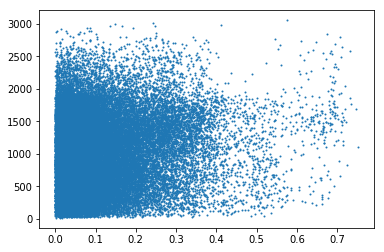

In [210]:
combinations = list(itertools.combinations(X, 2))
price_distances = [price_distance(x[0],x[1]) for x in combinations]
location_distances = [location_distance(x[0],x[1]) for x in combinations]

plt.scatter(price_distances,location_distances,s=1)


In [211]:
def building_distance(x, y):
    lat1, lon1, price1 = x[0], x[1], x[2]
    lat2, lon2, price2 = y[0], y[1], y[2]
    distance = geodesic((lat1, lon1), (lat2, lon2)).meters
    price_diff = abs(price1-price2)
    return distance*price_diff


combinations = list(itertools.combinations(X, 2))
distances = [building_distance(x[0],x[1]) for x in combinations]
distances_df = pd.DataFrame.from_dict({"distances":distances})
distances_df.describe()


,distances
count,43365.000000
mean,116.061037
std,154.517579
min,0.000716
25%,21.512403
50%,60.222901
75%,147.208621
max,1977.962021


(array([1.18648604e-02, 7.67362790e-03, 5.53079470e-03, 4.09679861e-03,
        3.27021061e-03, 2.63598795e-03, 2.04956515e-03, 1.71613192e-03,
        1.52609829e-03, 1.16818219e-03, 1.04460204e-03, 8.27753845e-04,
        7.58968666e-04, 6.42383618e-04, 6.15569056e-04, 5.00149858e-04,
        4.98984008e-04, 4.37193932e-04, 3.54418548e-04, 3.85896511e-04,
        2.93794322e-04, 2.92628472e-04, 2.45994452e-04, 2.40165200e-04,
        2.21511592e-04, 1.67882470e-04, 1.30575254e-04, 1.34072806e-04,
        1.57389816e-04, 1.08424095e-04, 1.01428992e-04, 1.03760693e-04,
        5.82925243e-05, 5.71266738e-05, 6.06242253e-05, 5.24632719e-05,
        5.47949728e-05, 5.36291223e-05, 3.96389165e-05, 4.08047670e-05,
        1.74877573e-05, 2.68145612e-05, 2.79804117e-05, 2.09853087e-05,
        1.98194583e-05, 1.74877573e-05, 1.51560563e-05, 1.04926544e-05,
        1.98194583e-05, 1.63219068e-05, 2.09853087e-05, 5.82925243e-06,
        4.66340194e-06, 9.32680389e-06, 6.99510291e-06, 1.049265

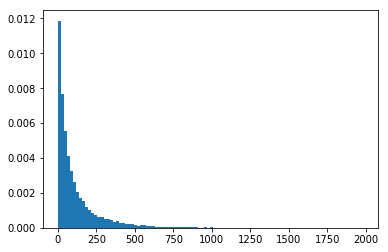

In [212]:
plt.hist(distances,bins=100,density=True)

Counter({1: 115, 0: 71, 4: 36, 2: 24, 5: 15, 9: 6, 3: 5, 6: 5, 7: 5, 10: 4, 8: 3, 11: 3, 12: 3})


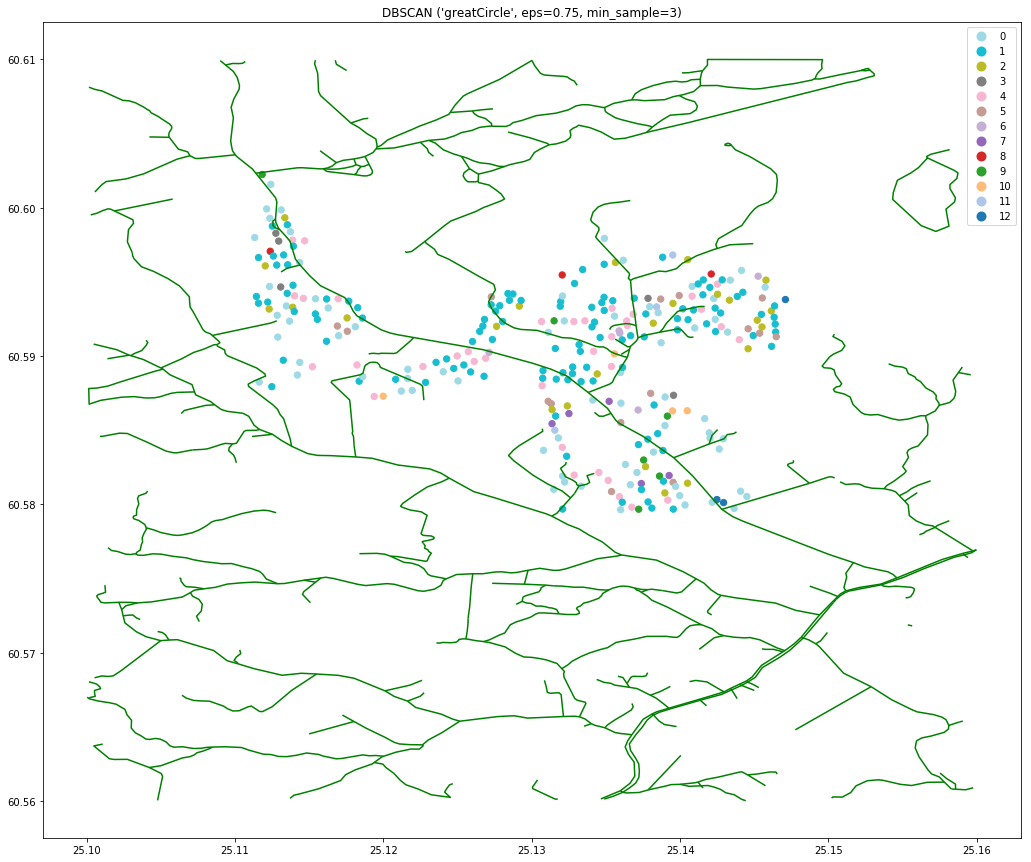

In [244]:
eps = [0.75]    # unit: euro/meter
min_sample = [3]
n1, n2 = 1,1
plt.subplots(nrows=len(eps)*len(min_sample)*2, ncols=1,figsize=(30,15))
index = 1
for j in range(len(min_sample)):
    for i in range(len(eps)):
        est = DBSCAN(eps=eps[i],min_samples=min_sample[j], metric=building_distance).fit(X)
        labels = list(map(lambda label:label+1, est.labels_.tolist()))
        labels_counter = Counter(labels)
        print(labels_counter)
#         print("{} noises".format(labels.count(0)))
        mean_gdf['cluster'] = labels
        ax = plt.subplot(len(eps)*len(min_sample), 1, index)
        plot_buildings(ax, mean_gdf, map_df)
        index+=1
        ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))
#         ax2 = plt.subplot(len(eps)*len(min_sample), 1, index)
# #         index+=1
#         ax2.hist(labels, bins=np.arange(np.min(labels),np.max(labels)))
#         plt.show()

In [249]:
mean_gdf.head()

,longitude,latitude,price,geometry,cluster
0,25.111322,60.597996,0.396242,POINT (25.1113221030974 60.59799640000001),0
1,25.111436,60.594018,0.069304,POINT (25.1114360484518 60.59401750000001),1
2,25.111576,60.593566,0.066982,POINT (25.1115756 60.59356555),1
3,25.111578,60.596643,0.079904,POINT (25.11157836658041 60.5966426),1
4,25.111624,60.588245,0.198940,POINT (25.1116239464851 60.58824545),0


In [251]:
df_grouped_cluster = df_grouped.merge(mean_gdf[["longitude","latitude","cluster"]],"inner",["longitude","latitude"])

In [252]:
df_grouped_cluster.head()

,longitude,latitude,price_sqm,living_area_sqm,price,cluster
0,25.111322,60.597996,[4594],[127.5],[585735.0],0
1,25.111436,60.594018,"[5550, 4143]","[27.0, 55.0]","[149850.0, 227865.0]",1
2,25.111576,60.593566,[2953],[63.0],[186039.0],1
3,25.111578,60.596643,"[4703, 5610]","[50.0, 30.0]","[235150.0, 168300.0]",1
4,25.111624,60.588245,"[6543, 4482]","[25.0, 118.0]","[163575.0, 528876.0]",0


In [253]:
df

import json
json.loads(df_grouped_cluster.loc[df_grouped_cluster["cluster"]==3].to_json(orient="records"))

In [272]:
list(df_grouped_cluster["cluster"].unique())

[0, 1, 9, 2, 8, 3, 4, 5, 10, 6, 7, 11, 12]

# kodit_frontend
The distributed version of this webapp is being hosted at https://serene-thicket-22556.herokuapp.com/  
## Installation  
`
git clone git@github.com:midofit/kodit_frontend.git  
`  
`
cd kodit_frontend
`  
Install dependencies  
`
npm install
`  
## Development  
To run the development server:

`
npm start
`  
The development version will be served at port 6076. Optionally the Rekit studio is available to use at port 6076  

## Test  
To run the tests:  
`
npm test
`  
## Build
To build the production version:  
`
npm run build
`  
After the build phase is finished, you can find the bundle in the build folder
  